In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import json
from PIL import Image
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
# Config
data_dir = "../data/flower_data"
out_dir = "../outputs"
train_dir = data_dir + "/dataset/train"
valid_dir = data_dir + "/dataset/valid"
test_dir = data_dir + "/dataset/test"
name_json = data_dir + "/cat_to_name.json"

# Load Label Mapping
with open(name_json, "r") as f:
    cat_to_name = json.load(f)

In [3]:
# Helper Functions & Classes
def pil_loader(path):
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for dirpath, _, filenames in os.walk(self.path):
            for f in filenames:
                if f.endswith(".jpg"):
                    p = {}
                    p["img_path"] = dirpath + "/" + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]["img_path"]
        img_name = img_path.split("/")[-1]
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0, img_name


class Lookahead(torch.optim.Optimizer):
    r"""Implements Lookahead optimizer.
    It's been proposed in paper: Lookahead Optimizer: k steps forward, 1 step back
    (https://arxiv.org/pdf/1907.08610.pdf)
    Args:
        optimizer: The optimizer object used in inner loop for fast weight updates.
        alpha:     The learning rate for slow weight update.
                   Default: 0.5
        k:         Number of iterations of fast weights updates before updating slow
                   weights.
                   Default: 5
    """

    def __init__(self, optimizer, alpha=0.5, k=5):
        assert 0.0 <= alpha <= 1.0
        assert k >= 1
        self.optimizer = optimizer
        self.defaults = optimizer.defaults
        self.param_groups = self.optimizer.param_groups
        self.alpha = alpha
        self.k = k
        self.state = defaultdict(dict)
        for group in self.param_groups:
            group["k_counter"] = 0
        self.slow_weights = [
            [param.clone().detach() for param in group["params"]] for group in self.param_groups
        ]
        super(Lookahead, self).__init__(self.param_groups, self.defaults)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group, slow_Weight in zip(self.param_groups, self.slow_weights):
            group["k_counter"] += 1
            if group["k_counter"] == self.k:
                for param, weight in zip(group["params"], slow_Weight):
                    weight.data.add_(self.alpha, (param.data - weight.data))
                    param.data.copy_(weight.data)
                group["k_counter"] = 0
        return loss

    def state_dict(self):
        fast_dict = self.optimizer.state_dict()
        fast_state = fast_dict["state"]
        param_groups = fast_dict["param_groups"]
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v for k, v in self.state.items()
        }
        return {"fast_state": fast_state, "param_groups": param_groups, "slow_state": slow_state}

    def load_state_dict(self, state_dict):
        fast_dict = {"state": state_dict["fast_state"], "param_groups": state_dict["param_groups"]}
        slow_dict = {"state": state_dict["slow_state"], "param_groups": state_dict["param_groups"]}
        super(Lookahead, self).load_state_dict(slow_dict)
        self.optimizer.load_state_dict(fast_dict)

In [4]:
# Lightning Module
class FlowerClassifier(pl.LightningModule):
    def __init__(self, lr=1e-2):
        super().__init__()
        self.save_hyperparameters()

        # Model setup: ResNet18
        self.model = models.resnet18(pretrained=True)

        # Freeze parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace FC layer
        self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=102)

        # Unfreeze FC parameters
        for param in self.model.fc.parameters():
            param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(), lr=self.hparams.lr, momentum=0.9, weight_decay=1e-4
        )
        # optimizer = Lookahead(optimizer)
        return optimizer

In [5]:
# Transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)

data_transforms = transforms.Compose(
    [
        transforms.Pad(4, padding_mode="reflect"),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        normalize,
    ]
)

# Datasets & Loaders
bs = 64
train_datasets = datasets.ImageFolder(train_dir, data_transforms)
val_datasets = datasets.ImageFolder(valid_dir, test_transforms)
test_datasets = TestDataset(test_dir, test_transforms)

trainloader = DataLoader(
    train_datasets, batch_size=bs, shuffle=True, num_workers=4, persistent_workers=True
)
validloader = DataLoader(
    val_datasets, batch_size=bs, shuffle=False, num_workers=4, persistent_workers=True
)
testloader = DataLoader(test_datasets, batch_size=1, shuffle=False, num_workers=0)

In [6]:
# Training
model = FlowerClassifier(lr=1e-2)

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=out_dir,
    filename="resnet18-{epoch:02d}-{val_acc:.2f}",
    monitor="val_acc",
    mode="max",
    save_top_k=1,
)

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
)

print("Starting training...")
trainer.fit(model, trainloader, validloader)
print("Training finished.")

/Users/yukonoff/code/hse_ai_24/uk-flowers/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yukonoff/code/hse_ai_24/uk-flowers/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Starting training...


/Users/yukonoff/code/hse_ai_24/uk-flowers/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/yukonoff/code/hse_ai_24/uk-flowers/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /Users/yukonoff/code/hse_ai_24/uk-flowers/outputs exists and is not empty.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet           │ 11.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 52.3 K                                                                                           
Non-trainable params: 11.2 M                                                                                       
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 69                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


Training finished.


In [9]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

device(type='mps')

In [ ]:
# Prediction
model.eval()
model.to(device)  # Or "cpu"

idx_to_class = {val: key for key, val in val_datasets.class_to_idx.items()}
result = dict()

print("Starting prediction...")
with torch.no_grad():
    for i, (input, _, path) in enumerate(testloader):
        input = input.to(device)
        output = model(input)
        _, pred = output.max(dim=1)
        predicted_idx = pred[0].item()
        result[path[0]] = idx_to_class[predicted_idx]

print(f"Prediction finished. Processed {len(result)} images.")

Starting prediction...
Prediction finished. Processed 819 images.



Random examples:


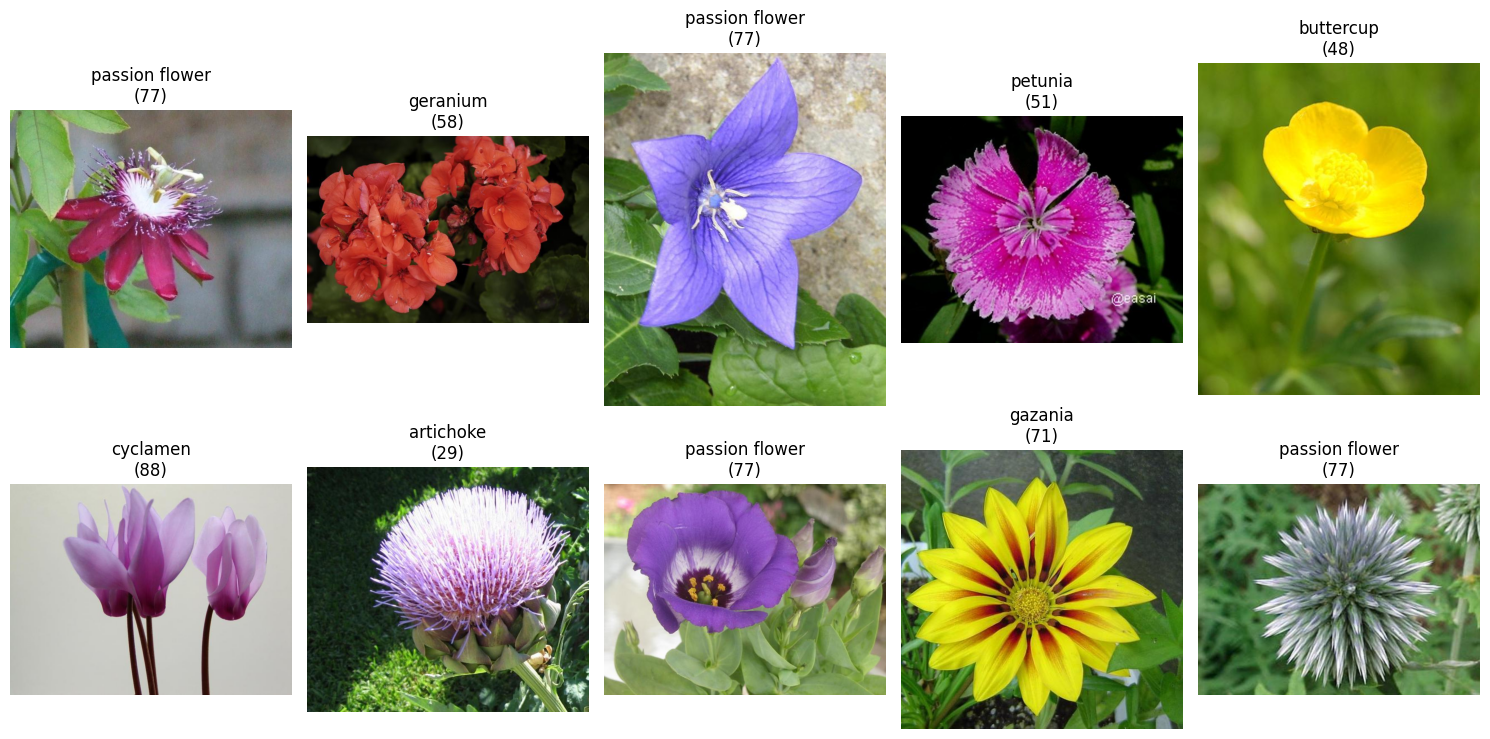

In [20]:
import random
import matplotlib.pyplot as plt

# Load class names
with open(name_json, "r") as f:
    cat_to_name = json.load(f)

# Display 10 random examples
print("\nRandom examples:")
keys = list(result.keys())
random.shuffle(keys)

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i, key in enumerate(keys[:10]):
    predicted_class = result[key]
    class_name = cat_to_name[predicted_class]

    # Find the image path
    # We need to search in test_dir recursively because TestDataset does that
    img_path = None
    for dirpath, _, filenames in os.walk(test_dir):
        if key in filenames:
            img_path = os.path.join(dirpath, key)
            break

    if img_path:
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{class_name}\n({predicted_class})")
            axes[i].axis("off")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            axes[i].axis("off")
    else:
        print(f"File not found: {key}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()